In [16]:
import matplotlib.pyplot as plt
from typing import List, Tuple
import tqdm as tqdm
import numpy as np
import cv2
import os

In [17]:
### Constants ###
# Path to the descriptor files
TEST_FOLDERS = ["side_demo_kpt_des_10_40", "side_demo_kpt_des_20_40", "side_demo_kpt_des_10_20", "side_demo_kpt_des_20_20"]
HUMMING_DISTANCES = [40, 40, 20, 20]
DESCRIPTOR_FILE_PATH = "side_demo_kpt_des"      
DESCRIPTOR_FILE = "side_demo_kpt_des"
# The maximum distance between two matched keypoints
MAX_MATCH_DISTANCE = 40             
# THe nummber of frames in an interval
FRAMES_PER_INTERVAL = 10
# Maximum number of intervals
MAX_INTERVALS = 100
# Create a BFMatcher object with Hamming distance (suitable for ORB, BRIEF, etc.)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)            

In [18]:
def load_kpt_des() -> List[List[np.ndarray]]:
    """
    description: Load KPT descriptors from the files for 4 different test sets.
    return      {List[List[np.ndarray]]}: A list containing four lists, each with descriptors for each interval.
    """
    all_descriptors = []

    for test_folder in TEST_FOLDERS: # You can replace these with appropriate folder names
        # List of all the descriptors for a single test
        descriptors = []
        # Index of the files
        i = 0   
        # Load and save all the descriptors from the file
        while True:
            file_name = f"../{test_folder}/{DESCRIPTOR_FILE}{i + 1}.yml"
            if os.path.exists(file_name):
                file_storage = cv2.FileStorage(file_name, cv2.FILE_STORAGE_READ)
                # Load the descriptors from the file
                descriptors.append(file_storage.getNode("descriptors").mat())
                file_storage.release()
                i += 1
            else:
                break
        all_descriptors.append(descriptors)
    return all_descriptors

def compare_descriptors(descriptors1: np.ndarray, descriptors2: np.ndarray) -> list:
    """
    description: Compare two sets of descriptors using BFMatcher.
    param       {np.ndarray} descriptors1: Descriptors from the first set.
    param       {np.ndarray} descriptors2: Descriptors from the second set.
    return      {list}: A list containing pairs of matching keypoints' indices (queryIdx, trainIdx).
    """
    # Match descriptors from two intervals
    if descriptors1 is None or descriptors2 is None:
        return []
    raw_matches = bf.match(descriptors1, descriptors2)
    # Extract pairs of matching keypoints' indices from the matches
    raw_matches = [m for m in raw_matches if m.distance < MAX_MATCH_DISTANCE]
    matches = [(match.queryIdx, match.trainIdx) for match in raw_matches]
    return matches

def process_data(all_descriptors: List[List[np.ndarray]]) -> List[np.ndarray]:
    """
    description: Process the data to get the matches between each pair of intervals for all the descriptor sets.
    param       {List[List[np.ndarray]]} all_descriptors: List containing four lists, each with descriptors for each interval.
    return      {List[np.ndarray]}: A list containing the results for all descriptor sets.
    """
    all_results = []
    for descriptors in all_descriptors:
        # List of all the matches
        all_matches = []
        # Extract pairs of matching keypoints' indices from the matches
        for i in range(len(descriptors) - 1):
            current_matches = compare_descriptors(descriptors[i], descriptors[i + 1])
            all_matches.append(current_matches)
        all_results.append(all_matches)
    return all_results

def compare_matches(all_matches: np.ndarray, descriptors: np.ndarray) -> np.ndarray:
    """
    description: Compare the matches between each pair of intervals.
    param       {np.ndarray} all_matches: DataFrame containing the matches between each pair of intervals.
    return      {np.ndarray}: A list containing the matches between each pair of intervals.
    """
    # List to store the continuous matches and the terminal matches
    continues_keypoints = []
    terminated_keypoints = []
    # Extract pairs of matching keypoints' indices from the matches
    with tqdm.tqdm(total=len(all_matches)) as pbar:
        for i, matches in enumerate(all_matches):
            pbar.update(1)
            if not matches:
                continue
            # Extract the indices of the matching keypoints
            match_pair_1, match_pair_2 = zip(*matches)
            # Extract the indices of the matching keypoints from the last interval
            last_matches = [x[1] for x in continues_keypoints]
            for j in range(len(descriptors[i])):
                if j in match_pair_1:
                    if j in last_matches:
                        index = last_matches.index(j)
                        continues_keypoints[index][1] = match_pair_2[
                            match_pair_1.index(j)
                        ]
                        continues_keypoints[index][3] = i + 2
                    else:
                        continues_keypoints.append(
                            [j, match_pair_2[match_pair_1.index(j)], i + 1, i + 2]
                        )
                else:
                    if j in last_matches:
                        terminated_keypoints.append(
                            continues_keypoints[last_matches.index(j)]
                        )
                    else:
                        terminated_keypoints.append([j, j, 1 + i, 1 + i])

            # Remove the keypoints in consecutive matches that has terminated
            continues_keypoints = [
                x for x in continues_keypoints if x not in terminated_keypoints
            ]
    terminated_keypoints.extend(continues_keypoints)
    return terminated_keypoints

In [19]:
# Load the descriptors from the file
print("Loading descriptors...")
all_descriptors = load_kpt_des()
for descriptors in all_descriptors:
    print(len(descriptors), "intervals found.")
print("Processing data...")
all_results = process_data(all_descriptors)
for all_matches in all_results:
    print(len(all_matches), "pairs of matches found.")
print("Comparing matches...")
all_compared_results = []
max_pairs = 0
for i in range(len(all_results)):
    all_compared_results.append(compare_matches(all_results[i], all_descriptors[i]))
    max_pairs = max(max_pairs, len(all_compared_results[-1]))
    print(len(all_compared_results[-1]), "keypoints found.")
# all_compared_results = compare_matches(all_results, all_descriptors)
# for compared_results in all_compared_results:
#     print(len(compared_results), "keypoints found.")

Loading descriptors...
100 intervals found.
50 intervals found.
100 intervals found.
50 intervals found.
Processing data...
99 pairs of matches found.
49 pairs of matches found.
99 pairs of matches found.
49 pairs of matches found.
Comparing matches...


100%|██████████| 99/99 [00:00<00:00, 208.86it/s]


5806 keypoints found.


100%|██████████| 49/49 [00:00<00:00, 1015.42it/s]


2083 keypoints found.


100%|██████████| 99/99 [00:00<00:00, 2982.48it/s]


2158 keypoints found.


100%|██████████| 49/49 [00:00<00:00, 37347.06it/s]

468 keypoints found.


In [20]:
plt.rc("font", family = "serif")
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 24)
plt.rc("ytick", labelsize = 24)
plt.rc("figure", figsize = (12, 6))
plt.rc("legend", fontsize = 18)
plt.rc("axes", titlesize = 36)
plt.rc("axes", labelsize = 32)

100%|██████████| 468/468 [00:00<00:00, 3105.12it/s]


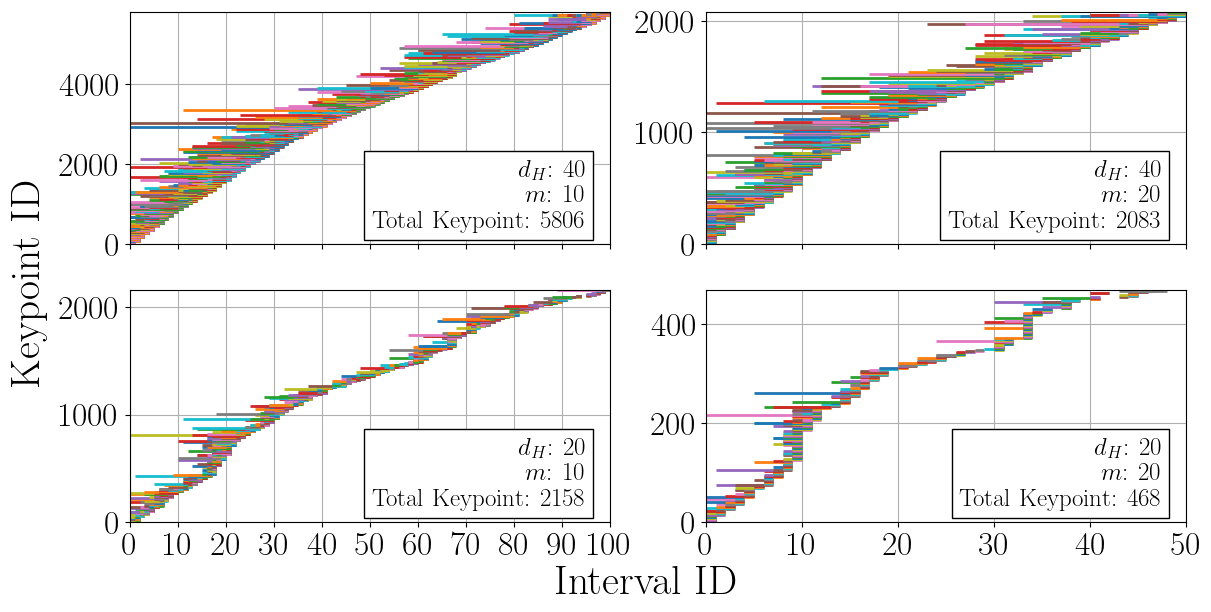

In [21]:
def plot_combined_timeline(
    processed_data_list: list, all_descriptors: list, savefig: bool
) -> None:
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))  # Adjusted to 2x2 layout

    for idx, processed_data in enumerate(processed_data_list):
        ax_row = idx // 2  # Determine row index
        ax_col = idx % 2  # Determine column index
        ax = axs[ax_row][ax_col]

        with tqdm.tqdm(total=len(processed_data)) as pbar:
            for data_idx, item in enumerate(processed_data):
                pbar.update(1)
                start_interval = item[2] - 1
                end_interval = item[3]
                color = default_colors[data_idx % len(default_colors)]
                ax.hlines(data_idx, start_interval, end_interval, colors=color, lw=2)

        ax.set_xlim(0, len(all_descriptors[idx]))
        ax.set_ylim(0, len(processed_data))
        ax.set_xticks(np.arange(0, len(all_descriptors[idx]) + 1, 10))
        ax.grid()
        if ax_row == 0:  # Only label the x-axis for bottom row
            ax.set_xticklabels([])
        # else:
        #     ax.set_yticklabels([])
        # Add custom text to the bottom right of each subplot
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        label_props = {
            "boxstyle": "square, pad=0.3",
            "facecolor": "white",
            "edgecolor": "black",
        }
        custom_text = f"$d_H$: {HUMMING_DISTANCES[idx]}\n$m$: {int(1000/len(all_descriptors[idx]))}\nTotal Keypoint: {len(processed_data)}"
        ax.text(
            xlim[1] * 0.95,
            ylim[1] * 0.05,
            custom_text,
            horizontalalignment="right",
            verticalalignment="bottom",
            bbox=label_props,
            fontsize=18,
            fontweight="bold",
        )

    # Create labels for the entire figure
    fig.text(
        0.5,
        -0.02,
        "Interval ID",
        horizontalalignment="center",
        fontsize=30,
        fontweight="bold",
    )
    fig.text(
        -0.03,
        0.5,
        "Keypoint ID",
        verticalalignment="center",
        rotation="vertical",
        fontsize=30,
        fontweight="bold",
    )
    plt.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.95)  # Adjusting subplot margins
    plt.show()

    if savefig:
        fig.savefig("../Results/combined_timeline.pdf", bbox_inches="tight")


plot_combined_timeline(all_compared_results, all_descriptors, True)

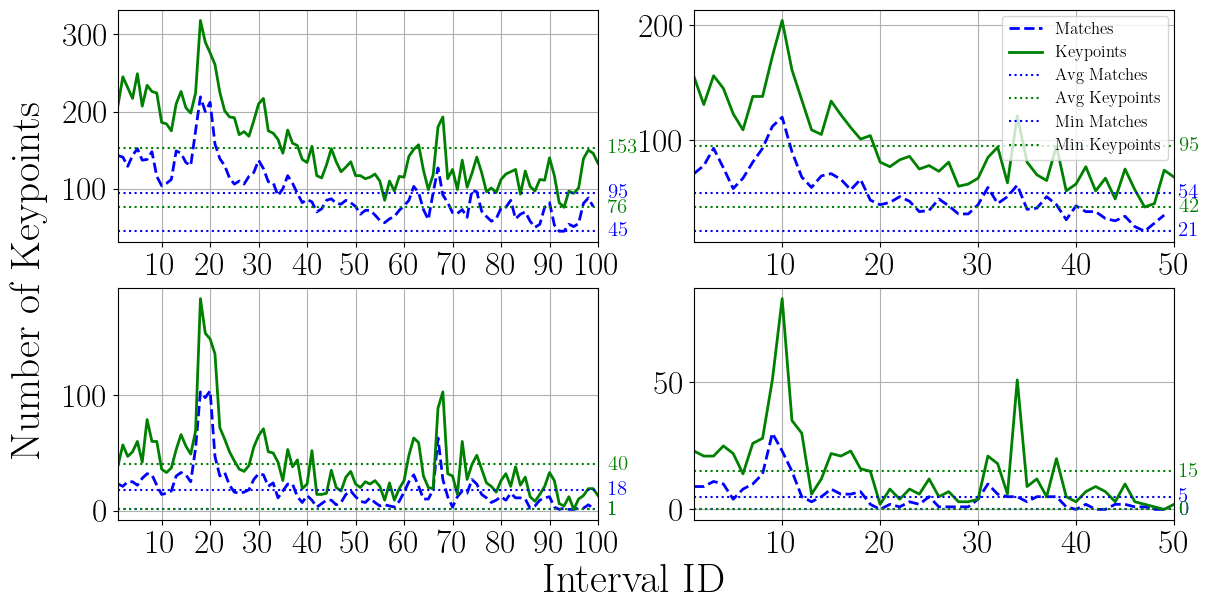

In [23]:
def plot_continuity(all_matches_list: list, all_descriptors_list: list, savefig: bool) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    for idx, (all_matches, descriptors) in enumerate(zip(all_matches_list, all_descriptors_list)):
        ax = axs[idx // 2, idx % 2]

        matches_numbers = [len(all_matches[i]) for i in range(len(all_matches))]
        keypoints_numbers = [len(descriptors[i]) if descriptors[i] is not None else 0 for i in range(len(descriptors))]

        avg_matches = int(np.mean(matches_numbers))
        avg_keypoints = int(np.mean(keypoints_numbers))
        min_matches = int(np.min(matches_numbers))
        min_keypoints = int(np.min(keypoints_numbers))

        margin = 1.03
        ax.text(margin * len(matches_numbers), avg_matches, f"{avg_matches}", va="center", ha="left", color="blue", fontsize=15)
        ax.text(margin * len(matches_numbers), avg_keypoints, f"{avg_keypoints}", va="center", ha="left", color="green", fontsize=15)
        ax.text(margin * len(matches_numbers), min_matches, f"{min_matches}", va="center", ha="left", color="blue", fontsize=15)
        ax.text(margin * len(matches_numbers), min_keypoints, f"{min_keypoints}", va="center", ha="left", color="green", fontsize=15)

        ax.plot(
            np.arange(1, len(matches_numbers) + 1),
            matches_numbers,
            linestyle = "--",
            label="Matches",
            color="blue",
            linewidth = 2,
        )
        ax.plot(
            np.arange(1, len(keypoints_numbers) + 1),
            keypoints_numbers,
            label="Keypoints",
            color="green",
            linewidth = 2,
        )
        ax.set_xticks(np.arange(0, len(matches_numbers) + 2, 10))
        ax.set_xlim(1, len(matches_numbers) + 1)

        ax.axhline(avg_matches, label="Avg Matches", color="blue", linestyle=":")
        ax.axhline(avg_keypoints, label="Avg Keypoints", color="green", linestyle=":")
        ax.axhline(min_matches, label="Min Matches", color="blue", linestyle=":")
        ax.axhline(min_keypoints, label="Min Keypoints", color="green", linestyle=":")



        ax.grid(True)

        # Set legend on the last subplot
        
        if idx == 1:
            plt.rc("legend", fontsize =12)
            ax.legend(loc="upper right", bbox_to_anchor=(1.005, 1.01))

    # Set common labels
   # Create labels for the entire figure
    fig.text(
        0.5,
        -0.02,
        "Interval ID",
        horizontalalignment="center",
        fontsize=30,
        fontweight="bold",
    )
    fig.text(
        -0.02,
        0.5,
        "Number of Keypoints",
        verticalalignment="center",
        rotation="vertical",
        fontsize=30,
        fontweight="bold",
    )
    plt.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.95)  # Adjusting subplot margins
    plt.show()

    if savefig:
        fig.savefig("../Results/combined_continuity.pdf",bbox_inches="tight")

plot_continuity(all_results, all_descriptors, True)